In [5]:
# install for AWS
!pip install torch
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install matplotlib
!pip install torchvision
!pip install s3fs
# !pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 67.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.57
    Uninstalling botocore-1.31.57:
      Successfully uninstalled botocore-1.31.57
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.28.57 requires botocore<1.32.0,>=1.31.57, but you have botocore 1.31.17 which is incompatible.
awscli 1.29.57 requires botocore==1.31.57, but you have botocore 1.31.17 which is incompatible.


In [6]:
import os
import torch
import pandas as pd
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import botocore.exceptions
# import fiftyone as fo
# import fiftyone.brain as fob
# import fiftyone.zoo as foz
# from fiftyone import ViewField as F

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from io import BytesIO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


# Load and Split

In [7]:
# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

In [8]:
# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

In [9]:
# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}annotations.csv'
df = pd.read_csv(annotations_s3_path)

In [10]:
classes = df['class1'].unique()

idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

idx_to_annot = {i: j for i, j in enumerate(df.columns[6:])}

In [11]:
def count_jpg_files(bucket_name, prefix=''):
    """
    Count the number of .jpg files in an S3 bucket under a given prefix.
    
    Parameters:
    - bucket_name (str): Name of the S3 bucket.
    - prefix (str): Prefix path to filter results. Default is empty.
    
    Returns:
    - count (int): Count of .jpg files.
    """
    count = 0
    paginator = s3_client.get_paginator('list_objects_v2')
    
    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'].endswith('.jpg'):
                count += 1

    return count

# Count .jpg files in the 'w210facetdata' bucket under the 'images/' prefix
jpg_count = count_jpg_files(bucket_name, images_prefix)
print(f"Number of .jpg files in the '{bucket_name}/{images_prefix}' path: {jpg_count}")


Number of .jpg files in the 'w210facetdata/images/' path: 31702


In [12]:
df.iloc[0][6:]

gender_presentation_masc          0
gender_presentation_fem           1
gender_presentation_non_binary    0
gender_presentation_na            0
skin_tone_1                       2
skin_tone_2                       3
skin_tone_3                       0
skin_tone_4                       0
skin_tone_5                       0
skin_tone_6                       0
skin_tone_7                       0
skin_tone_8                       0
skin_tone_9                       0
skin_tone_10                      0
skin_tone_na                      0
age_presentation_young            0
age_presentation_older            0
age_presentation_middle           1
age_presentation_na               0
hair_color_brown                  0
hair_color_blonde                 1
hair_color_grey                   0
hair_color_na                     0
hair_color_black                  0
hair_color_colored                0
hair_color_red                    0
hairtype_coily                    0
hairtype_dreadlocks         

In [13]:
idx_to_class

{0: 'gymnast',
 1: 'boatman',
 2: 'lifeguard',
 3: 'backpacker',
 4: 'lawman',
 5: 'dancer',
 6: 'laborer',
 7: 'patient',
 8: 'basketball_player',
 9: 'nurse',
 10: 'singer',
 11: 'motorcyclist',
 12: 'astronaut',
 13: 'fireman',
 14: 'referee',
 15: 'speaker',
 16: 'guitarist',
 17: 'repairman',
 18: 'craftsman',
 19: 'guard',
 20: 'painter',
 21: 'doctor',
 22: 'farmer',
 23: 'drummer',
 24: 'climber',
 25: 'disk_jockey',
 26: 'soccer_player',
 27: 'student',
 28: 'soldier',
 29: 'cheerleader',
 30: 'flutist',
 31: 'runner',
 32: 'retailer',
 33: 'machinist',
 34: 'reporter',
 35: 'horseman',
 36: 'tennis_player',
 37: 'computer_user',
 38: 'carpenter',
 39: 'seller',
 40: 'skateboarder',
 41: 'gardener',
 42: 'waiter',
 43: 'prayer',
 44: 'ballplayer',
 45: 'sculptor',
 46: 'teacher',
 47: 'electrician',
 48: 'hairdresser',
 49: 'judge',
 50: 'trumpeter',
 51: 'bartender'}

In [14]:
batch_size = 32
learning_rate = 0.001
num_classes = 52
num_epochs = 1

In [15]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [16]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)


In [17]:
# toggle on/off subsetting
# Define the number of samples you want in your subset
subset_size = 10  # Adjust the size as needed

# Create a smaller subset of your dataset
train_data = train_data[:subset_size]
test_data = test_data[:subset_size]
val_data = val_data[:subset_size]

In [18]:
# Define additional metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Lists to store metric values during training
train_losses_student, val_losses_student, train_losses_teacher, val_losses_teacher = [], [], [], []
train_accuracies_student, val_accuracies_student, train_accuracies_teacher, val_accuracies_teacher = [], [], [], []


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class CustomDataset(Dataset):
    def __init__(self, split_data, image_dir, transform=None):
        self.data = split_data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 2]
        image_key = f'{images_prefix}{img_name}'  # Construct S3 object key
        # Load image from S3
        img_object = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        img_data = img_object['Body'].read()
        # Open the image directly from the byte stream using PIL
        image = Image.open(BytesIO(img_data))
        annotations = self.data.iloc[idx, 6:].values.astype(np.float16).reshape(-1, 1)
        label = class_to_idx[self.data.iloc[idx, 3]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label), torch.from_numpy(annotations)

# Create custom datasets and data loaders
image_dir = 'FACET'  # Local directory if you want to save images locally
train_dataset = CustomDataset(split_data=train_data, image_dir=image_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(split_data=test_data, image_dir=image_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_dataset = CustomDataset(split_data=val_data, image_dir=image_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


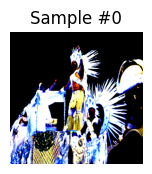

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


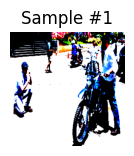

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


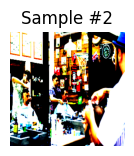

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


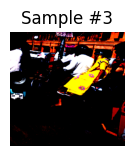

In [21]:
fig = plt.figure()

for i, sample in enumerate(train_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(np.transpose(sample[0], [1,2,0]))
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.show()
    if i == 3:
        break


# Model

In [22]:
# device = torch.device('mps')

# Define your smaller ResNet student model
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=52):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(131072, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=52):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(65536, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define loss functions
criterion_teacher = nn.CrossEntropyLoss()  # Loss for teacher model
criterion_student = nn.KLDivLoss()  # Knowledge distillation loss

# Instantiate the teacher and student models
teacher_model = torchvision.models.resnet50(pretrained=True)
num_ftrs = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs, num_classes)
teacher_model = teacher_model.to(device)

student_model = LightNN(num_classes=num_classes).to(device)  # Adjust num_classes as needed

# Define optimizer for the student model
optimizer_student = optim.Adam(student_model.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


# Train


In [23]:
# Define attributes and concepts in your dataset
attributes = df.columns[6:].tolist()  # All attributes
concepts = list(idx_to_class.values())  # All concepts

# Create a dictionary to map attribute names to column indices
attr_idx = {attr: idx for idx, attr in enumerate(attributes)}

# Initialize dictionaries to store recall values for teacher and student models
teacher_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
student_recall_values = {attr: {concept: [] for concept in concepts} for attr in attributes}



In [24]:
disparity_weight = 0.1  # Adjust as needed
alpha = 0.5  # Adjust as needed


In [25]:
# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Training loop
for epoch in range(num_epochs):
    student_model.train()
    teacher_model.train()
    for images, labels, annotations in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_student.zero_grad()
        optimizer_teacher.zero_grad()

        # Forward pass
        teacher_outputs = teacher_model(images).to(device)
        student_outputs = student_model(images).to(device)

        # Calculate additional metrics including recall
        recall_student = recall_score(labels.cpu().numpy(), torch.argmax(student_outputs, dim=1).cpu().numpy(), average='weighted')
        recall_teacher = recall_score(labels.cpu().numpy(), torch.argmax(teacher_outputs, dim=1).cpu().numpy(), average='weighted')

        # Update recall values
        for attr in attributes:
            for concept in concepts:
                # Check if the sample belongs to the specified attribute and concept
                attr_indices = np.where(annotations[:, attr_idx[attr]].cpu().numpy() == 1)[0]  # Get indices where attribute is 1
                concept_indices = np.where(labels.cpu().numpy() == class_to_idx[concept])[0]  # Get indices where concept matches
                common_indices = np.intersect1d(attr_indices, concept_indices)  # Common indices
                if common_indices.size > 0:
                    teacher_recall_values[attr][concept].append(recall_teacher)
                    student_recall_values[attr][concept].append(recall_student)

        # Calculate the loss
        kd_loss = criterion_student(
            F.log_softmax(student_outputs / 5, dim=1),  # Apply temperature scaling
            F.softmax(teacher_outputs / 5, dim=1)  # Apply temperature scaling
        )
        ce_loss = criterion_teacher(student_outputs, labels)
        
    # Calculate the disparity for each attribute and concept
    for attr in attributes:
        for concept in concepts:
            # Calculate the disparity (difference in recall)
            teacher_recall = np.mean(teacher_recall_values[attr][concept])
            student_recall = np.mean(student_recall_values[attr][concept])
            disparity = teacher_recall - student_recall
    
            # Clone tensors before performing inplace operations
            kd_loss = kd_loss.clone()
            ce_loss = ce_loss.clone()
            disparity_tensor = torch.tensor(disparity, dtype=torch.float32).to(device)  # Convert disparity to a PyTorch tensor
            disparity_loss = disparity_weight * disparity_tensor.clone()
            total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + disparity_loss
    
    # Perform the backward pass with retain_graph=True
    total_loss.backward(retain_graph=True)
    
    # Optimize the models
    optimizer_student.step()
    optimizer_teacher.step()

# Disable anomaly detection when done
torch.autograd.set_detect_anomaly(False)


In [26]:
# Validation
student_model.eval()
teacher_model.eval()
val_loss_student = 0.0
val_predictions_student = []
val_targets_student = []

val_loss_teacher = 0.0
val_predictions_teacher = []
val_targets_teacher = []

with torch.no_grad():
    for images, labels, annotations in val_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        student_outputs = student_model(images)
        teacher_outputs = teacher_model(images)

        # Calculate cross-entropy loss for validation
        student_loss = criterion_teacher(student_outputs, labels)
        teacher_loss = criterion_teacher(teacher_outputs, labels)

        val_loss_student += student_loss.item()
        val_loss_teacher += teacher_loss.item()

        # Store predictions and ground truth labels for metrics
        val_predictions_student.extend(torch.argmax(student_outputs, dim=1).cpu().numpy())
        val_predictions_teacher.extend(torch.argmax(teacher_outputs, dim=1).cpu().numpy())

        val_targets_student.extend(labels.cpu().numpy())
        val_targets_teacher.extend(labels.cpu().numpy())

# Calculate validation accuracy and recall
val_accuracy_student = accuracy_score(val_targets_student, val_predictions_student)
val_accuracy_teacher = accuracy_score(val_targets_teacher, val_predictions_teacher)
val_recall_student = recall_score(val_targets_student, val_predictions_student, average='weighted')
val_recall_teacher = recall_score(val_targets_teacher, val_predictions_teacher, average='weighted')

# Calculate disparity for validation
val_disparity_values = {attr: {concept: [] for concept in concepts} for attr in attributes}
for attr in attributes:
    for concept in concepts:
        # Calculate the disparity for validation
        teacher_recall_val = np.mean(teacher_recall_values[attr][concept])
        student_recall_val = np.mean(student_recall_values[attr][concept])
        disparity_val = teacher_recall_val - student_recall_val
        val_disparity_values[attr][concept] = disparity_val

# Print validation results for this epoch
print(f'Epoch [{epoch+1}/{num_epochs}]'
      f' Teacher Loss: {val_loss_teacher / len(val_loader):.4f}'
      f' Teacher Accuracy: {val_accuracy_teacher:.4f}'
      f' Teacher Recall: {val_recall_teacher:.4f}'
      f' Student Loss: {val_loss_student / len(val_loader):.4f}'
      f' Student Accuracy: {val_accuracy_student:.4f}'
      f' Student Recall: {val_recall_student:.4f}')

# Print disparity for validation
for attr in attributes:
    for concept in concepts:
        print(f'Validation Disparity for {attr} and {concept}: {val_disparity_values[attr][concept]:.4f}')


Epoch [1/1] Teacher Loss: 4.2939 Teacher Accuracy: 0.0000 Teacher Recall: 0.0000 Student Loss: 10.4819 Student Accuracy: 0.0000 Student Recall: 0.0000
Validation Disparity for gender_presentation_masc and gymnast: nan
Validation Disparity for gender_presentation_masc and boatman: 0.0000
Validation Disparity for gender_presentation_masc and lifeguard: 0.0000
Validation Disparity for gender_presentation_masc and backpacker: nan
Validation Disparity for gender_presentation_masc and lawman: nan
Validation Disparity for gender_presentation_masc and dancer: 0.0000
Validation Disparity for gender_presentation_masc and laborer: nan
Validation Disparity for gender_presentation_masc and patient: nan
Validation Disparity for gender_presentation_masc and basketball_player: nan
Validation Disparity for gender_presentation_masc and nurse: nan
Validation Disparity for gender_presentation_masc and singer: nan
Validation Disparity for gender_presentation_masc and motorcyclist: 0.0000
Validation Dispari

In [27]:
torch.save(student_model.state_dict(), 'student_model2.pth')

In [28]:
torch.save(teacher_model.state_dict(), 'teacher_model2.pth')

In [29]:
accuracy_score(val_targets_student, val_predictions_student)

0.0

In [30]:
accuracy_score(val_targets_teacher, val_predictions_teacher)

0.0

In [31]:
val_loss_student / len(val_loader)

10.48187255859375

In [32]:
val_loss_teacher / len(val_loader)

4.293878555297852

# Evaluate

In [ ]:
student_model.eval()
for images, labels, annotation in val_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = student_model(images)
    
    # Assuming you're working with a classification model, find the predicted class index
    predicted = torch.argmax(outputs, dim=1).cpu().numpy()
    predicted_class = predicted[13]
    labels = labels.cpu().numpy()[13]
    annotations = annotation.cpu().numpy()[13]
    # Display the image and its predicted class
    image = images[13].permute(1, 2, 0).cpu().numpy()  # Convert the tensor to a numpy array and adjust dimensions
    plt.imshow(image)
    plt.title(f'Predicted Class: {idx_to_class[predicted_class]}        |         Label: {idx_to_class[labels]}')
    plt.show()
    break  # Stop after displaying the first image


In [ ]:
student_model.eval()
for images, labels, annotation in val_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = student_model(images)
    
    # Assuming you're working with a classification model, find the predicted class index
    predicted = torch.argmax(outputs, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    recall = recall_score(labels, predicted, average='weighted')
    break


In [ ]:
recall

In [ ]:
def get_attributes_from_annotations(annotations):
    attributes = set()

    for i in range(len(annotations)):
        if annotations[i][0] != 0:
            attributes.add(idx_to_annot[i])

    return attributes

In [ ]:
get_attributes_from_annotations(annotations)